# Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Loading

In [ ]:
uploaded = files.upload()

Saving airlines_flights_data.csv to airlines_flights_data.csv


Reading file using read_csv method and display first 5 rows from the dataset

In [ ]:
df = pd.read_csv("airlines_flights_data.csv")
df.head()

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Display last 5 rows from the dataset

In [ ]:
df.tail()

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


Displaying columns' names to facilite analysis

In [ ]:
df.columns        # duration in hours

Index(['index', 'airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [ ]:
print("The shape of data: ",df.shape)

The shape of data:  (300153, 12)


The dataset is very large it contains near 300000 row and 11 columns

# Dataset info. and describtion

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


The majority of data is object and we have only 3 numeric columns


In [ ]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


From describe we can conclude that the data contains outliers due to difference between mean and median and min,max value in every numeric column

# Cleaning

In [ ]:
df = df.drop(columns=['index'])

Drop index column bec it is not necessary for our analysis

In [ ]:
print("Number of duplicated rows: ",df.duplicated().sum())

Number of duplicated rows:  0


The data doesn't have any duplicates

In [ ]:
df.isnull().sum()

,0
airline,0
flight,0
source_city,0
departure_time,0
stops,0
arrival_time,0
destination_city,0
class,0
duration,0
days_left,0


The data is clean and doesn't have any missing value

## Outliers

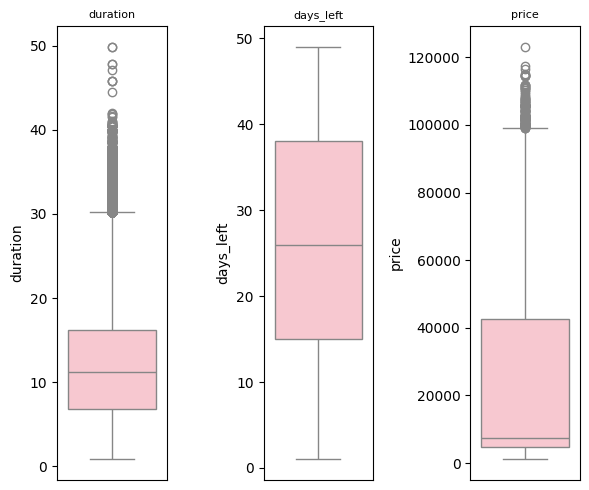

In [ ]:
numeric_cols = df.select_dtypes(include=['number'])   # select numeric columns

# expecting the columns of {0,1} values
filtered_cols = [col for col in numeric_cols if not set(df[col].dropna().unique()).issubset({0, 1})]

# plot boxplot
plt.figure(figsize=(len(filtered_cols)*2, 5))

for i, col in enumerate(filtered_cols, 1):
    plt.subplot(1, len(filtered_cols), i)
    sns.boxplot(y=df[col], color='pink')
    plt.title(col, fontsize=8)
    plt.xticks([])
    plt.tight_layout()

plt.show()

Display outliers by boxblot and we can conclude that the two column from three contain outliers (duration , price)

In [ ]:
def outlier_ratio(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    total_rows = len(df)
    outlier_counts = {}

    total_outliers = set()

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_counts[col] = len(outliers)
        total_outliers.update(outliers)

    overall_outliers = len(total_outliers)
    ratio = overall_outliers / total_rows * 100

    print(" Outliers per column:")
    for col, count in outlier_counts.items():
        print(f"- {col}: {count} outliers")

    print(f"\n Total rows: {total_rows}")
    print(f" Total unique outliers: {overall_outliers}")
    print(f" Outlier ratio: {ratio:.2f}%\n")

    return outlier_counts, overall_outliers, ratio

print("Summary: ",outlier_ratio(df))

 Outliers per column:
- duration: 2110 outliers
- days_left: 0 outliers
- price: 123 outliers

 Total rows: 300153
 Total unique outliers: 2233
 Outlier ratio: 0.74%

Summary:  ({'duration': 2110, 'days_left': 0, 'price': 123}, 2233, 0.7439539168357472)


Here we displayed outliers in details
outliers don't take a large space in the data, it just take less than 1% so we will remove it

In [ ]:
def remove_outliers_iqr(df):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    outlier_indices = set()

    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].index
        outlier_indices.update(outliers)


    df_clean = df_clean.drop(index=outlier_indices)

    return df_clean

df_clean = remove_outliers_iqr(df)
print("The shape of data after removing outliers: ",df_clean.shape)

The shape of data after removing outliers:  (297920, 11)


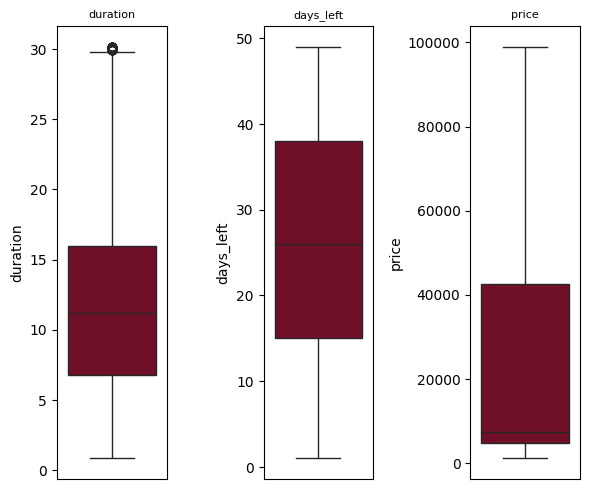

In [ ]:
numeric_cols = df_clean.select_dtypes(include=['number'])       # select numeric columns

# plot boxplots
plt.figure(figsize=(len(filtered_cols)*2, 5))

for i, col in enumerate(filtered_cols, 1):
    plt.subplot(1, len(filtered_cols), i)
    sns.boxplot(y=df_clean[col], color='#800020')
    plt.title(col, fontsize=8)
    plt.xticks([])

plt.tight_layout()
plt.show()

We wanted to check if the outliers have handled so we ploted a new boxblot to cleaned_df and the outliers have been removed (there is a little in duration but not a huge difference between it and the normal data)

# Exploratory Data Analysis (EDA)

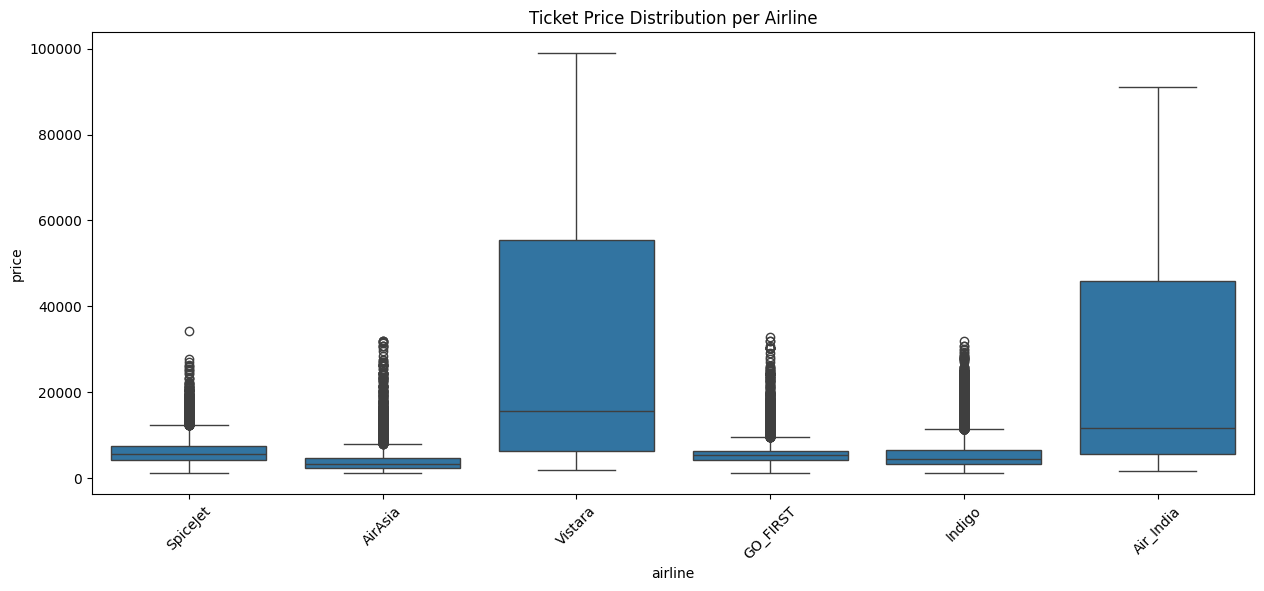

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x="airline", y="price", data=df_clean)
plt.xticks(rotation=45)
plt.title("Ticket Price Distribution per Airline")
plt.show()

SpiceJetو AirAsia, GO_FIRST, Indigo prices are close and low high<br> Visatra, Air_India have ver noticable high prices <br> <strong>This means  that airline has high impact on ticket prices</strong>

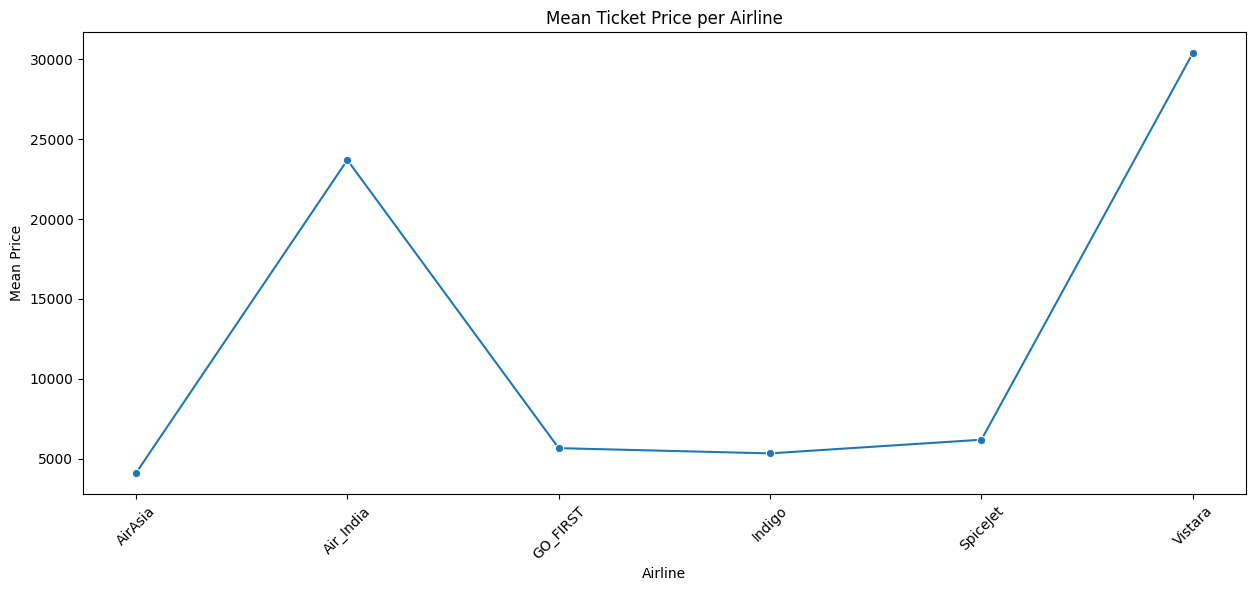

In [ ]:
mean_prices = df_clean.groupby("airline")["price"].mean().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(x="airline", y="price", data=mean_prices, marker="o")
plt.xticks(rotation=45)
plt.title("Mean Ticket Price per Airline")
plt.ylabel("Mean Price")
plt.xlabel("Airline")
plt.show()

This plot confirms the last insight as the mean of SpiceJetو AirAsia, GO_FIRST, Indigo price are close <br> and the mean of Visatra, Air_India are very noticably high

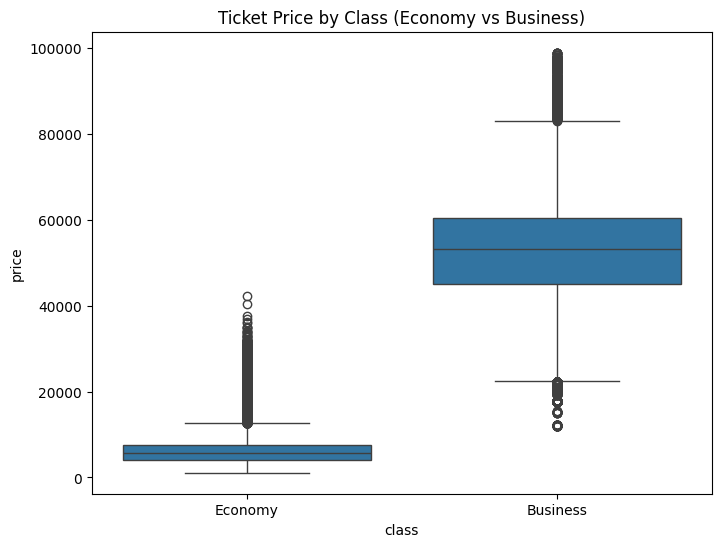

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x="class", y="price", data=df_clean)
plt.title("Ticket Price by Class (Economy vs Business)")
plt.show()

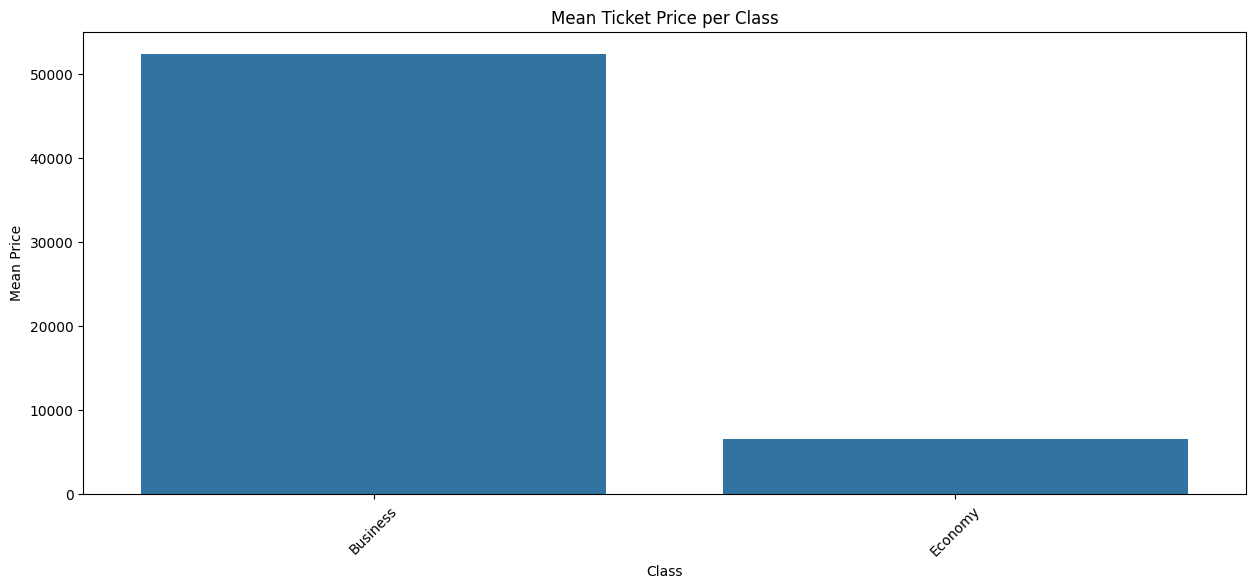

In [ ]:
mean_prices2 = df_clean.groupby("class")["price"].mean().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(x="class", y="price", data=mean_prices2)
plt.xticks(rotation=45)
plt.title("Mean Ticket Price per Class")
plt.ylabel("Mean Price")
plt.xlabel("Class")
plt.show()

Class is very important in setting the ticket prices, economy class is much lower than business class

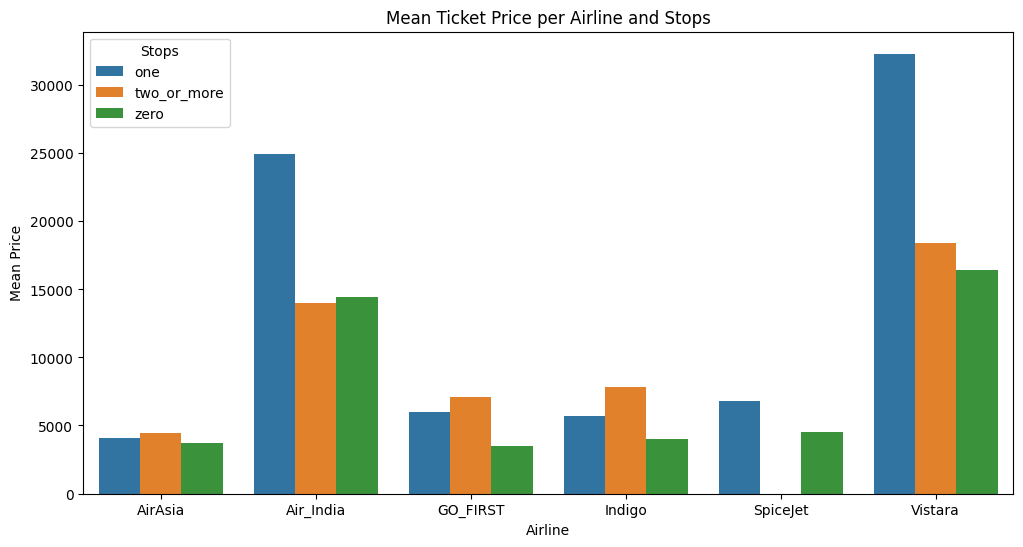

In [ ]:
mean_prices_edited = df_clean.groupby(["airline", "stops"])["price"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x="airline", y="price", hue="stops", data=mean_prices_edited, estimator=np.mean)
plt.title("Mean Ticket Price per Airline and Stops")
plt.ylabel("Mean Price")
plt.xlabel("Airline")
plt.legend(title="Stops")
plt.show()

- **Low-cost airlines**: non-stop flights are usually cheaper, while one-stop flights cost more.  
- **Higher airlines (Vistara, Air India)**: one-stop flights are much more expensive than non-stop.  
- in conclusion, the **airline has a stronger impact on price than the number of stops**.

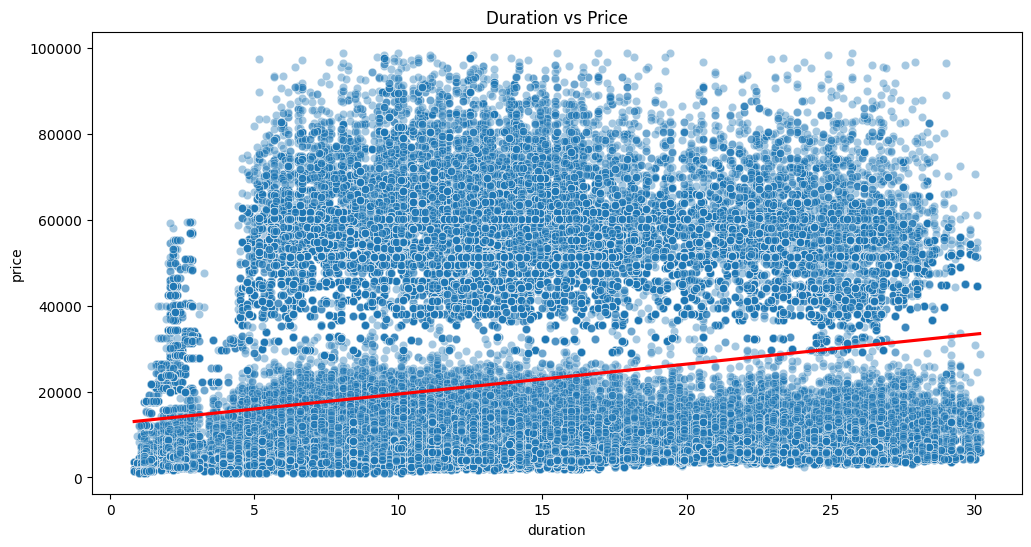

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x="duration", y="price", data=df_clean, alpha=0.4)
plt.title("Duration vs Price")
sns.regplot(x="duration", y="price", data=df_clean, scatter=False, line_kws={"color": "red"})
plt.show()

Red line illustrates a weak +ve relation between durarion and price, it is weak because there's several tickets with same price for different durations<br><strong>Duration slightly affect price but not a strong affect as the other factors (class, airline)</strong>

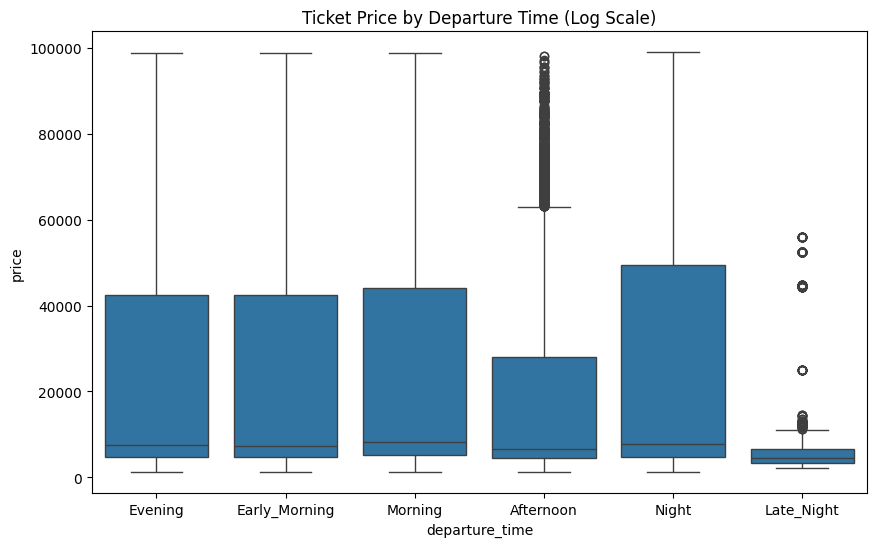

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x="departure_time", y="price", data=df_clean)
plt.title("Ticket Price by Departure Time (Log Scale)")
plt.show()

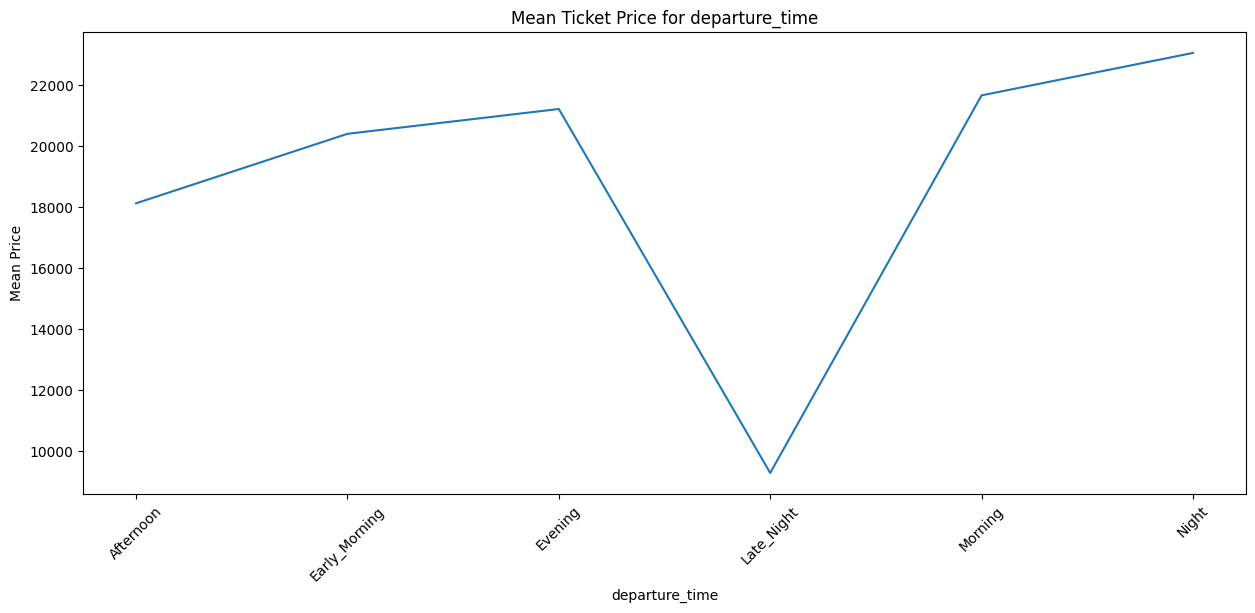

In [ ]:
mean_prices3 = df_clean.groupby("departure_time")["price"].mean().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(x="departure_time", y="price", data=mean_prices3)
plt.xticks(rotation=45)
plt.title("Mean Ticket Price for departure_time")
plt.ylabel("Mean Price")
plt.xlabel("departure_time")
plt.show()

Late night: Cheapest option<br>
Night: Most expensive<br>
Afternoon: Moderate pricing<br>
Evening/Morning: Similar prices<br>
<strong> In conclusion, duration significantly affect ticket prices

# ML Model

## Data Preparing

In [ ]:
features = [
    'airline', 'source_city', 'departure_time',
    'arrival_time', 'destination_city', 'stops',
    'class', 'duration', 'days_left'
]
target = 'price'

## Scikit Learn DT Model

/tmp/ipython-input-4066188845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['stops'] = x['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})
/tmp/ipython-input-4066188845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['class'] = x['class'].map({'Economy': 0, 'Business': 1})


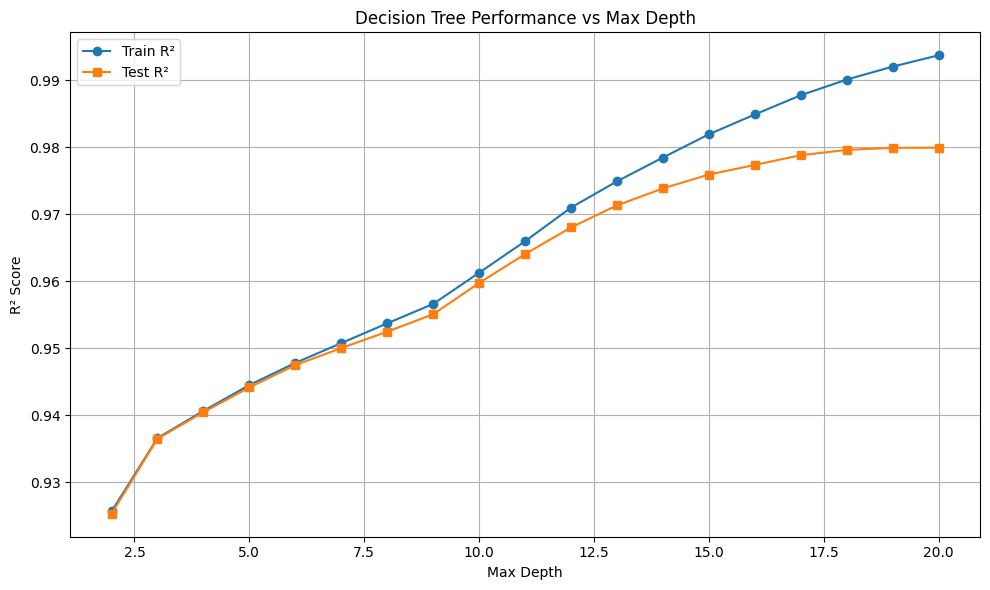

In [ ]:
x = df_clean[features]
y = df_clean[target]

# Encoding
x['stops'] = x['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})
x['class'] = x['class'].map({'Economy': 0, 'Business': 1})

# will use in freq encoding
freq_cols = ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city']

# Data splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Frequency Encoding
for col in freq_cols:
    freq = x_train[col].value_counts(normalize=True)
    x_train[col] = x_train[col].map(freq)
    x_test[col] = x_test[col].map(freq).fillna(0)

# Model Selection
train_r2 = []
test_r2 = []
depths = range(2, 21)

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(x_train, y_train)

    r2_train = r2_score(y_train, model.predict(x_train))
    r2_test = r2_score(y_test, model.predict(x_test))

    train_r2.append(r2_train)
    test_r2.append(r2_test)

# Plot training r2 and test r2
plt.figure(figsize=(10, 6))
plt.plot(depths, train_r2, label='Train R²', marker='o')
plt.plot(depths, test_r2, label='Test R²', marker='s')
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Decision Tree Performance vs Max Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Build the Model by best parameters  (max_depth = 15)

In [ ]:
# Train Decision Tree
model = DecisionTreeRegressor(max_depth= 15, random_state=42)
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
y_train_pred = model.predict(x_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Train R²: {r2_train:.4f}")
print(f"Test R²:  {r2_test:.4f}")

Mean Absolute Error: 1732.55
Mean Squared Error: 12417149.88
Train R²: 0.9819
Test R²:  0.9759


## LightGBM Regressor Model

/tmp/ipython-input-2864472570.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/tmp/ipython-input-2864472570.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/tmp/ipython-input-2864472570.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 9
[LightGBM] [Info] Start training from score 20888.572417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

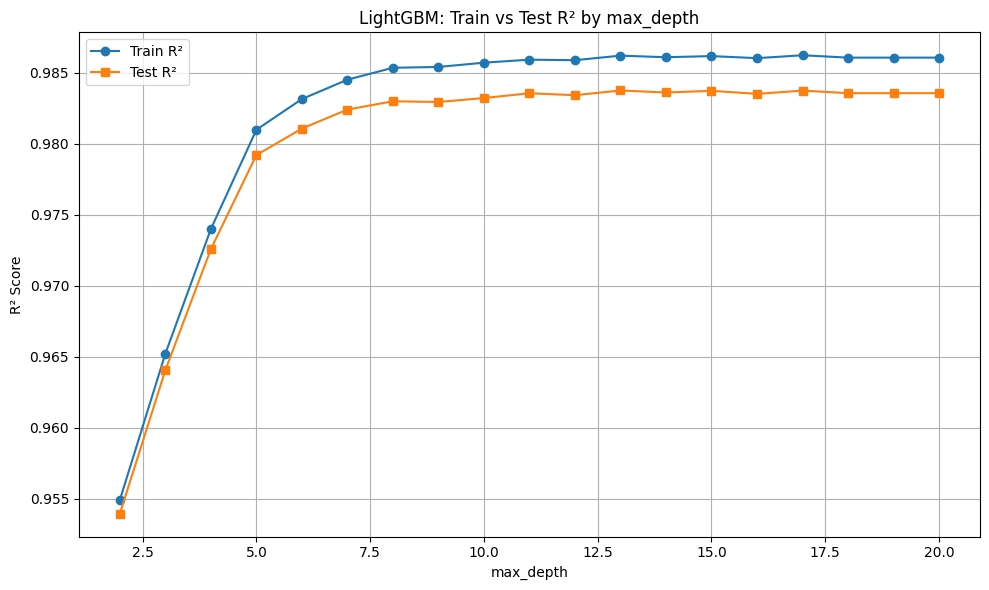

In [ ]:
X = df_clean[features]
y = df_clean[target]

# Categorical features
categorical_features = [
    'airline', 'source_city', 'departure_time',
    'arrival_time', 'destination_city', 'stops', 'class'
]
for col in categorical_features:
    X[col] = X[col].astype('category')

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection
train_r2 = []
test_r2 = []
depths = range(2, 21)

for depth in depths:
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=depth,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        categorical_feature=categorical_features,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
    )

    # Predictions and scores
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

# Plot training r2 and test r2
plt.figure(figsize=(10, 6))
plt.plot(depths, train_r2, label='Train R²', marker='o')
plt.plot(depths, test_r2, label='Test R²', marker='s')
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.title('LightGBM: Train vs Test R² by max_depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Build the Model by best parameters  (max_depth = 15)

In [ ]:
# Initialize and Train LightGBM regressor
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=15,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=categorical_features,
)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'\nMean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')

y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Train R²: {r2_train:.4f}")
print(f"Test R²:  {r2_test:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 9
[LightGBM] [Info] Start training from score 20888.572417

Mean Absolute Error: 1601.19
Mean Squared Error: 8386989.59
Train R²: 0.9862
Test R²:  0.9837


### Save the final Model

In [ ]:
import joblib
joblib.dump(model, 'flight_price_prediction_model.pkl')